# Clustering exploration

In [2]:
import altair as alt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import defaultdict

In [3]:
import pickle 

## load dfs from PCA file

In [4]:
dft_piv = pd.read_csv("../mat_save/dft_piv.tsv",sep='\t').fillna('')
mdf_piv = pd.read_csv("../mat_save/mdf_piv.tsv",sep='\t').fillna('')
mdf_piv_norm = pd.read_csv("../mat_save/mdf_piv_norm.tsv",sep='\t').fillna('')
mdf_piv_norm_nocu = pd.read_csv("../mat_save/mdf_piv_norm_nocu.tsv",sep='\t').fillna('')
mdf_piv_norm_nocu_subset = pd.read_csv("../mat_save/mdf_piv_norm_nocu_subset.tsv",sep='\t').fillna('')


In [5]:
mdf_piv.head()

,locus_tag,LanzaTech,MeOH,NO3_lowO2_slow_growth,NoCu,NoLanthanum,WT_control,WithLanthanum,aa3_KO,crotonic_acid,...,unknown,gene_symbol,product,type,sys,pc1,pc2,pc3,tsne1,tsne2
0,EQU24_RS00005,25.626702,23.323155,32.040358,44.338687,33.434023,34.988452,35.452185,26.849583,38.684021,...,20.462977,dnaA,chromosomal replication initiator protein DnaA,CDS,other,-0.242597,0.032800,0.007199,3.469032,10.165356
1,EQU24_RS00010,55.711920,18.905775,43.646760,59.619360,43.679839,38.272163,41.782237,45.489035,52.507256,...,20.753038,,DNA polymerase III subunit beta,CDS,other,-0.224666,0.028974,0.002134,-3.114132,9.638032
2,EQU24_RS00015,11.804042,18.443916,21.341623,28.258717,23.162675,15.495930,20.634554,11.962099,33.132559,...,12.244885,recF,DNA replication/repair protein RecF,CDS,other,-0.259354,0.036802,0.009310,11.034661,5.924214
3,EQU24_RS00020,76.880335,18.257805,62.257687,56.808319,57.287047,54.855025,57.120166,55.846659,77.849631,...,29.602255,gyrB,DNA topoisomerase (ATP-hydrolyzing) subunit B,CDS,other,-0.215584,0.021422,0.007413,-2.505093,7.504429
4,EQU24_RS00025,43.737438,16.950643,41.674925,49.829406,42.357072,35.396786,34.248335,33.097353,49.837247,...,29.494437,,hypothetical protein,CDS,other,-0.236185,0.029925,0.006343,1.054558,8.750976


In [6]:
# establish list of samples and experiment conditions
coord_cols = ['pc1','pc2','pc3','tsne1','tsne2']
samples = list(dft_piv.drop(coord_cols,axis=1).select_dtypes(include=['float']).columns)
exp_conds = list(mdf_piv.drop(coord_cols,axis=1).select_dtypes(include=['float']).columns)
exp_subset = ['uMax','lowCH4','NoCu','lowCu','medCu','highCu','NO3_lowO2_slow_growth','highO2_slow_growth','lowO2_fast_growth','MeOH','NoLanthanum','WithLanthanum'] 

## K-means clustering and viz functions

In [7]:
def run_kmeans(df_orig,cols,k=20):
    # make of copy of the original df
    df = df_orig.copy(deep=True)
    
    # kmean object
    km = KMeans(
        n_clusters=k, init='random',
        n_init=10, max_iter=300, 
        tol=1e-04, random_state=0
    )

    scaler = StandardScaler()
    X = scaler.fit_transform(df[cols])

    y_km = km.fit_predict(X)
    

    df['cluster_id'] = y_km
    print(df.shape)
    
    return df,X

# count the number of genes per cluster
def count_clusters(clust_df):
    clusters = defaultdict(list)
    for i,row in clust_df.iterrows():
        clusters[row['cluster_id']].append(row['locus_tag'])

    clust_counts = []
    for c in clusters:
        clust_counts.append((c,len(clusters[c])))
    
    return clusters,clust_counts

def view_cluster_counts(clust_counts):
    clustdf = pd.DataFrame(clust_counts, 
              columns=["cluster","count"])

    sns.barplot(data=clustdf, x='cluster',y='count',palette='hls')
    plt.show()
#     return alt.Chart(clustdf
#              ).mark_bar().encode(
#         x='cluster:O',
#         y='count:Q'
#     )

def alt_3pcs_tsne(df,fname):
    '''
    Given a df with cluster ids and pcs, visualize pcs 1,2,3 with clusters colored
    '''
    def pc_chart(x,y,pc_title):
        sel = alt.selection_multi(fields=['cluster_id'], bind='legend')
        chart = alt.Chart(df,
                            title=f"{pc_title} (Genes)",
                            height=300,
                            width=300
                           ).mark_circle().encode(
            x=x,
            y=y,
            color=alt.Color('cluster_id:N',scale=alt.Scale(scheme='sinebow')),
            tooltip=['locus_tag:N', 'type:N','gene_symbol:N', 'product:N','sys:N','cluster_id:N'],
            opacity=alt.condition(sel, alt.value(1), alt.value(0.2)),
            size=alt.condition(sel, alt.value(200), alt.value(100)),
        ).add_selection(
            sel,
        ).interactive()
        
        return chart
    
    chart12 = pc_chart('pc1:Q', 'pc2:Q', 'PCA of PC 1 and 2')
    chart23 = pc_chart('pc2:Q', 'pc3:Q', 'PCA of PC 2 and 3')
    chart13 = pc_chart('pc1:Q', 'pc3:Q', 'PCA of PC 1 and 3')
    chart_tsne = pc_chart('tsne1:Q', 'tsne2:Q', 'TSNE')
    
#     display(chart12)
#     display(chart23)
#     display(chart13)
#     display(chart_tsne)
    chart12.save(f"../altair_out/clustered_{fname}_pc12.html")
    chart23.save(f"../altair_out/clustered_{fname}_pc23.html")
    chart13.save(f"../altair_out/clustered_{fname}_pc13.html")
    chart_tsne.save(f"../altair_out/clustered_{fname}_tsne.html")
    
def kmeans_bundle(df,cols,fname):
    df_clust, X = run_kmeans(df, cols)
    clusters, clust_counts = count_clusters(df_clust)
    view_cluster_counts(clust_counts)
    alt_3pcs_tsne(df_clust,fname)
    
    return df_clust, X, clusters, clust_counts
    

# NOTE: check "altair_out/" for altair viz! Or uncomment "display" `alt_3pcs_tsne()`

(4213, 109)


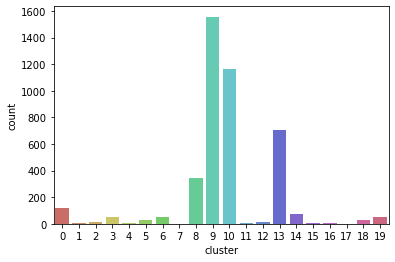

In [8]:
dft_piv_clust_df,\
dft_piv_clust_X, \
dft_piv_clusters,\
dft_piv_clust_counts = kmeans_bundle(dft_piv,samples,"genes_samp")

(4213, 30)


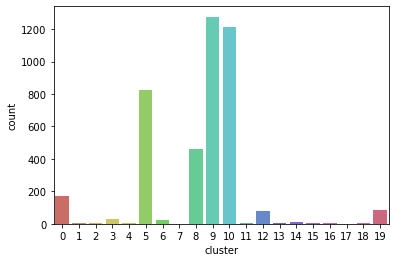

In [9]:
mdf_piv_clust_df,\
mdf_piv_clust_X, \
mdf_piv_clusters,\
mdf_piv_clust_counts = kmeans_bundle(mdf_piv,exp_conds,"genes_exp_ave")


(4213, 30)


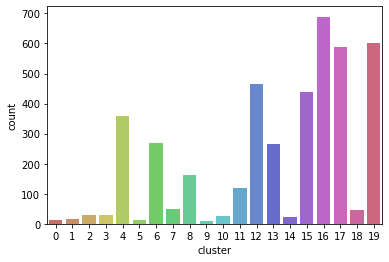

In [10]:
mdf_piv_norm_clust_df,\
mdf_piv_norm_clust_X, \
mdf_piv_norm_clusters,\
mdf_piv_norm_clust_counts = kmeans_bundle(mdf_piv_norm, exp_conds,"genes_exp_ave_norm")

(4213, 30)


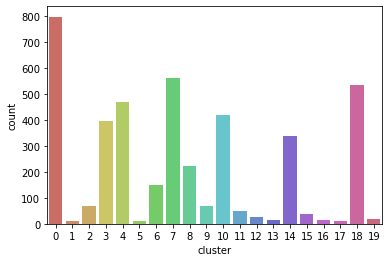

In [11]:
mdf_piv_norm_nocu_clust_df,\
mdf_piv_norm_nocu_clust_X, \
mdf_piv_norm_nocu_clusters,\
mdf_piv_norm_nocu_clust_counts = kmeans_bundle(mdf_piv_norm_nocu, exp_conds,"genes_exp_ave_norm_nocu")

(4213, 23)


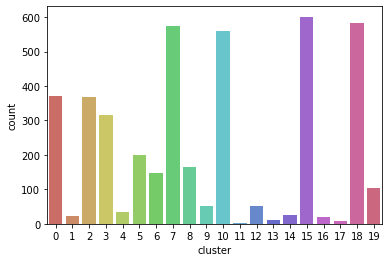

In [12]:
mdf_piv_norm_nocu_subset_clust_df,\
mdf_piv_norm_nocu_subset_clust_X, \
mdf_piv_norm_nocu_subset_clusters,\
mdf_piv_norm_nocu_subset_clust_counts = kmeans_bundle(mdf_piv_norm_nocu_subset, exp_subset,"genes_exp_ave_norm_nocu")

# Cluster expression visualizer!

In [13]:
def altair_pcoords(df,title,xorder='exp_condition_order'):
    # If more than 30 entries, make 2 columns
    col_num = 1 if len(df['locus_tag'].unique()) <=50 else 2
    
    highlight = alt.selection(type='single', on='mouseover',
                              fields=['desc_string'], nearest=True)
    
    selection = alt.selection_multi(fields=['desc_string'], bind='legend')


    base = alt.Chart(df.sort_values(xorder),
                     title=title
        ).encode(
        x=alt.X(f'{xorder}:N',
                sort=alt.EncodingSortField(field=f"{xorder}:N", op="count")
               ),
        y='mean:Q',
        color=alt.Color('desc_string:N',
                        legend=alt.Legend(title='Gene', 
                                          orient = 'right',
                                          labelLimit=0,
                                          columns=col_num,
                                          symbolLimit=200
                                         )),
        size=alt.value(100)        
    )
    

    lines = base.mark_line().encode(
        size=alt.condition((selection|highlight), alt.value(3), alt.value(1)),
        opacity=alt.condition((selection|highlight), alt.value(1), alt.value(0.5))
    ).add_selection(
        selection,
    ).properties(
         width=600,
         height=400
    ).interactive()
    
    
    points = base.mark_circle().encode(
        tooltip=['locus_tag','product','type','gene_symbol'],
        opacity=alt.condition((selection|highlight), alt.value(1), alt.value(0.2)),
        size=alt.condition((selection|highlight), alt.value(100), alt.value(3))
    ).add_selection(highlight)

    #return points + lines
    return lines + points

def check_cluster_expression(df, cols,cluster_id,title):
    df['desc_string'] = df.apply(lambda row: f"{row['locus_tag']}|{row['gene_symbol']}|{row['product']}",axis=1)
    id_vars = ['locus_tag','gene_symbol','product','type','sys','pc1','pc2','pc3','tsne1','tsne2','cluster_id','desc_string']
    dfm = df.melt(id_vars=id_vars, value_vars=cols,var_name='exp_condition',value_name="mean")
    # altair sort helper
    list_ordering = ['uMax','lowCH4','NoCu','lowCu','medCu','highCu','NO3_lowO2_slow_growth','highO2_slow_growth','lowO2_fast_growth','MeOH','NoLanthanum','WithLanthanum'] 
    dfm["exp_condition_order"] = pd.Categorical(dfm["exp_condition"], categories=list_ordering)
    return dfm
    #return altair_pcoords(dfm[dfm['cluster_id']==cluster_id],title)

In [14]:
check_cluster_expression(
    mdf_piv_norm_nocu_subset_clust_df, 
    exp_subset,
    2,
    "norm nocu subset, cluster 13")




,locus_tag,gene_symbol,product,type,sys,pc1,pc2,pc3,tsne1,tsne2,cluster_id,desc_string,exp_condition,mean,exp_condition_order
0,EQU24_RS00005,dnaA,chromosomal replication initiator protein DnaA,CDS,other,0.129112,0.747309,-0.130137,4.608102,2.881918,10,EQU24_RS00005|dnaA|chromosomal replication ini...,uMax,0.230940,uMax
1,EQU24_RS00010,,DNA polymerase III subunit beta,CDS,other,-0.114363,1.066466,0.477944,2.356631,9.390868,10,EQU24_RS00010||DNA polymerase III subunit beta,uMax,0.008731,uMax
2,EQU24_RS00015,recF,DNA replication/repair protein RecF,CDS,other,0.507340,0.951947,-0.047674,5.788600,2.503165,10,EQU24_RS00015|recF|DNA replication/repair prot...,uMax,0.263995,uMax
3,EQU24_RS00020,gyrB,DNA topoisomerase (ATP-hydrolyzing) subunit B,CDS,other,0.635571,1.032306,0.728887,7.629592,5.715142,10,EQU24_RS00020|gyrB|DNA topoisomerase (ATP-hydr...,uMax,0.322579,uMax
4,EQU24_RS00025,,hypothetical protein,CDS,other,-0.287465,0.613281,0.523996,-0.142253,9.382814,2,EQU24_RS00025||hypothetical protein,uMax,-0.034911,uMax
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50551,EQU24_RS22135,mnmE,tRNA uridine-5-carboxymethylaminomethyl(34) sy...,CDS,other,0.085859,2.510850,-0.387097,7.885776,8.792405,5,EQU24_RS22135|mnmE|tRNA uridine-5-carboxymethy...,WithLanthanum,-1.622939,WithLanthanum
50552,EQU24_RS22140,yidC,membrane protein insertase YidC,CDS,other,0.629347,2.605005,0.378352,10.011259,7.862389,5,EQU24_RS22140|yidC|membrane protein insertase ...,WithLanthanum,-1.370358,WithLanthanum
50553,EQU24_RS22145,yidD,membrane protein insertion efficiency factor YidD,CDS,other,0.738941,3.125333,-0.176227,10.671334,7.245647,8,EQU24_RS22145|yidD|membrane protein insertion ...,WithLanthanum,-1.902270,WithLanthanum
50554,EQU24_RS22150,rnpA,ribonuclease P protein component,CDS,other,0.949544,3.276559,-0.292540,10.818687,7.188185,8,EQU24_RS22150|rnpA|ribonuclease P protein comp...,WithLanthanum,-1.911077,WithLanthanum


In [53]:
df = mdf_piv_norm_nocu_clust_df
cols = exp_subset
df['desc_string'] = df.apply(lambda row: f"{row['locus_tag']}|{row['gene_symbol']}|{row['product']}",axis=1)
id_vars = ['locus_tag','gene_symbol','product','type','sys','pc1','pc2','pc3','tsne1','tsne2','cluster_id','desc_string']
dfm = df.melt(id_vars=id_vars, value_vars=cols,var_name='exp_condition',value_name="mean")

                             
list_ordering = ['uMax','lowCH4','NoCu','lowCu','medCu','highCu','NO3_lowO2_slow_growth','highO2_slow_growth','lowO2_fast_growth','MeOH','NoLanthanum','WithLanthanum'] 
dfm["exp_condition_order"] = pd.Categorical(dfm["exp_condition"], categories=list_ordering)
#return dfm
dfm[dfm['cluster_id']==13]

,locus_tag,gene_symbol,product,type,sys,pc1,pc2,pc3,tsne1,tsne2,cluster_id,desc_string,exp_condition,mean,exp_condition_order
3434,EQU24_RS18090,mxaL,VWA domain-containing protein,CDS,mox,0.399169,0.225773,1.718074,-9.657870,10.749016,13,EQU24_RS18090|mxaL|VWA domain-containing protein,uMax,0.231675,uMax
3435,EQU24_RS18095,mxaK,MxaK protein,CDS,mox,0.195769,0.343999,2.402215,-9.667781,10.756631,13,EQU24_RS18095|mxaK|MxaK protein,uMax,0.326731,uMax
3436,EQU24_RS18100,mxaC,VWA domain-containing protein,CDS,mox,0.283213,0.772952,1.770673,-9.670994,10.760220,13,EQU24_RS18100|mxaC|VWA domain-containing protein,uMax,0.303414,uMax
3437,EQU24_RS18105,mxaA,hypothetical protein,CDS,mox,0.836812,-0.234294,2.617763,-9.673179,10.756966,13,EQU24_RS18105|mxaA|hypothetical protein,uMax,0.180734,uMax
3438,EQU24_RS18110,mxaS,MxaS protein,CDS,mox,1.243752,0.758049,2.124203,-9.668708,10.756086,13,EQU24_RS18110|mxaS|MxaS protein,uMax,0.250464,uMax
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49787,EQU24_RS18140,moxF,"PQQ-dependent dehydrogenase, methanol/ethanol ...",CDS,mox,2.104665,-0.922394,3.918080,-9.685888,10.756698,13,EQU24_RS18140|moxF|PQQ-dependent dehydrogenase...,WithLanthanum,-1.060933,WithLanthanum
49788,EQU24_RS18145,mxaB,response regulator transcription factor,CDS,mox,2.568997,0.014210,1.596001,-9.629580,10.727956,13,EQU24_RS18145|mxaB|response regulator transcri...,WithLanthanum,-1.573271,WithLanthanum
49789,EQU24_RS18150,,CAP domain-containing protein,CDS,other,1.260025,1.332973,2.292102,-9.639710,10.742906,13,EQU24_RS18150||CAP domain-containing protein,WithLanthanum,-2.135000,WithLanthanum
49790,EQU24_RS18155,mxaD,SRPBCC family protein,CDS,other,3.932179,2.267901,2.129993,-9.624717,10.744054,13,EQU24_RS18155|mxaD|SRPBCC family protein,WithLanthanum,-3.553662,WithLanthanum


# Other analyses
* Was 20 a good choice for k?
  * "elbow method"
  * silhouette analysis
  * Are clusters stable?
* Try other clustering methods
  * DBSCAN
* Filter out extremely low expression genes

In [18]:
mdf_piv_norm_nocu_subset_clust_df

,locus_tag,gene_symbol,product,type,sys,uMax,lowCH4,NoCu,lowCu,medCu,...,MeOH,NoLanthanum,WithLanthanum,pc1,pc2,pc3,tsne1,tsne2,cluster_id,desc_string
0,EQU24_RS00005,dnaA,chromosomal replication initiator protein DnaA,CDS,other,0.230940,-0.524729,0.0,-0.045453,0.018499,...,-0.926800,-0.407248,-0.322691,0.129112,0.747309,-0.130137,4.608102,2.881918,10,EQU24_RS00005|dnaA|chromosomal replication ini...
1,EQU24_RS00010,,DNA polymerase III subunit beta,CDS,other,0.008731,-0.830648,0.0,0.037731,0.124682,...,-1.656949,-0.448812,-0.512890,-0.114363,1.066466,0.477944,2.356631,9.390868,10,EQU24_RS00010||DNA polymerase III subunit beta
2,EQU24_RS00015,recF,DNA replication/repair protein RecF,CDS,other,0.263995,-0.612638,0.0,0.028310,0.057570,...,-0.615548,-0.286893,-0.453632,0.507340,0.951947,-0.047674,5.788600,2.503165,10,EQU24_RS00015|recF|DNA replication/repair prot...
3,EQU24_RS00020,gyrB,DNA topoisomerase (ATP-hydrolyzing) subunit B,CDS,other,0.322579,-0.403321,0.0,0.115969,0.202817,...,-1.637584,0.012107,0.007898,0.635571,1.032306,0.728887,7.629592,5.715142,10,EQU24_RS00020|gyrB|DNA topoisomerase (ATP-hydr...
4,EQU24_RS00025,,hypothetical protein,CDS,other,-0.034911,-0.655542,0.0,0.032277,-0.032484,...,-1.555652,-0.234394,-0.540962,-0.287465,0.613281,0.523996,-0.142253,9.382814,2,EQU24_RS00025||hypothetical protein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4208,EQU24_RS22135,mnmE,tRNA uridine-5-carboxymethylaminomethyl(34) sy...,CDS,other,0.461614,-0.113483,0.0,0.030668,0.373198,...,-1.186188,-1.575671,-1.622939,0.085859,2.510850,-0.387097,7.885776,8.792405,5,EQU24_RS22135|mnmE|tRNA uridine-5-carboxymethy...
4209,EQU24_RS22140,yidC,membrane protein insertase YidC,CDS,other,0.765862,-0.160495,0.0,0.211253,0.423080,...,-1.437866,-1.208018,-1.370358,0.629347,2.605005,0.378352,10.011259,7.862389,5,EQU24_RS22140|yidC|membrane protein insertase ...
4210,EQU24_RS22145,yidD,membrane protein insertion efficiency factor YidD,CDS,other,0.719367,0.120205,0.0,0.199180,0.465012,...,-0.758655,-2.022364,-1.902270,0.738941,3.125333,-0.176227,10.671334,7.245647,8,EQU24_RS22145|yidD|membrane protein insertion ...
4211,EQU24_RS22150,rnpA,ribonuclease P protein component,CDS,other,0.832777,0.258714,0.0,0.206600,0.536093,...,-0.556765,-1.788852,-1.911077,0.949544,3.276559,-0.292540,10.818687,7.188185,8,EQU24_RS22150|rnpA|ribonuclease P protein comp...


In [70]:
loci_to_gene_symbol = dict(zip(mdf_piv_norm_nocu_clust_df['locus_tag'], mdf_piv_norm_nocu_clust_df['gene_symbol']))
loci_to_product = dict(zip(mdf_piv_norm_nocu_clust_df['locus_tag'], mdf_piv_norm_nocu_clust_df['product']))



pickle.dump(loci_to_gene_symbol, open("../data/loci2gene.p", "wb"))
pickle.dump(loci_to_gene_symbol, open("../data/loci2product.p", "wb"))
